In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_analytics.csv')
df = df[df['round'].isin(['Sweet 16', 'Elite Eight', 'Final Four', 'Championship'])]
print(df.shape)
df.head()

(135, 87)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,prpg!,...,D_B,D_C,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F
2,2015,Midwest,Sweet 16,1,2015 Kentucky,5,2015 West Virginia,1,9.0103,-0.6000,...,0,0,0,0,0,0,0,0,0,0
3,2015,Midwest,Elite Eight,1,2015 Kentucky,3,2015 Notre Dame,1,4.5163,-3.2000,...,0,0,0,0,0,0,0,0,0,0
5,2015,Final Four,Final Four,1,2015 Kentucky,1,2015 Wisconsin,0,1.7004,-7.2000,...,0,0,0,0,0,0,0,0,0,0
12,2015,Midwest,Sweet 16,3,2015 Notre Dame,7,2015 Wichita St.,1,4.0205,2.3000,...,0,0,0,0,0,0,0,0,0,0
18,2015,West,Sweet 16,1,2015 Wisconsin,4,2015 North Carolina,1,4.8764,5.9000,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df['win'].value_counts(normalize=True)

1   0.5481
0   0.4519
Name: win, dtype: float64

In [3]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_bracket_team',
       'low_bracket_seed', 'low_bracket_team', 'win', 'wab', 'prpg!', 'dprpg',
       'bpm', 'obpm', 'dbpm', 'bpr', 'obpr', 'dbpr', 'kenpom_adjem',
       'kenpom_adjoe', 'kenpom_adjde', 'barthag', 'barthag_oe', 'barthag_de',
       'off_eff', 'def_eff', 'efg%', 'ftr', 'tor', 'orb%', 'efgd%', 'ftrd',
       'tord', 'drb%', '2p%', '3p%', 'blked%', 'ast%', '3pr', 'ft%', '2p%d',
       '3p%d', 'blk%', 'ast%d', '3prd', 'ft%d', 'height', 'size', 'experience',
       'bench', 'high_tier', 'low_tier', 'S_S', 'S_A', 'S_B', 'S_C', 'S_D',
       'S_F', 'A_S', 'A_A', 'A_B', 'A_C', 'A_D', 'A_F', 'B_S', 'B_A', 'B_B',
       'B_C', 'B_D', 'B_F', 'C_S', 'C_A', 'C_B', 'C_C', 'C_D', 'C_F', 'D_S',
       'D_A', 'D_B', 'D_C', 'D_D', 'D_F', 'F_S', 'F_A', 'F_B', 'F_C', 'F_D',
       'F_F'],
      dtype='object')

In [4]:
eda_df = df[[
    'win', 
    'wab', 
    'prpg!', 
    'dprpg',
    'bpm', 
    'obpm', 
    'dbpm', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

In [6]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.29, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(95, 39)
(40, 39)


# I. Numerical Tests

In [7]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 20]
print(correlation_with_target)

wab             35.3700
prpg!           28.5200
bpm             34.3900
obpm            31.3300
kenpom_adjem    27.1400
kenpom_adjoe    40.0000
barthag         20.3400
barthag_oe      42.6700
off_eff         39.5300
efg%            29.3800
tor             22.7500
2p%             21.4300
3p%             27.4000
win            100.0000
Name: win, dtype: float64


In [8]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,13.2952,0.0004,0.0551
1,prpg!,8.2347,0.0051,0.0000
2,dprpg,0.3946,0.5314,0.0481
3,bpm,12.4763,0.0006,0.0648
4,obpm,10.1239,0.0020,0.1140
5,dbpm,2.6931,0.1042,0.0000
6,kenpom_adjem,7.3953,0.0078,0.1235
7,kenpom_adjoe,17.7148,0.0001,0.0916
8,kenpom_adjde,0.3748,0.5419,0.0573
9,barthag,4.0140,0.0480,0.0000


In [9]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,wab,13.2952,0.0004,0.0551
3,bpm,12.4763,0.0006,0.0648
4,obpm,10.1239,0.0020,0.1140
6,kenpom_adjem,7.3953,0.0078,0.1235
7,kenpom_adjoe,17.7148,0.0001,0.0916
8,kenpom_adjde,0.3748,0.5419,0.0573
10,barthag_oe,20.7071,0.0000,0.0802
12,off_eff,17.2239,0.0001,0.1059
17,orb%,0.2268,0.6350,0.0524
19,ftrd,0.2117,0.6465,0.0681


In [10]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,13.2952,0.0004,0.0551
1,prpg!,8.2347,0.0051,0.0000
3,bpm,12.4763,0.0006,0.0648
4,obpm,10.1239,0.0020,0.1140
6,kenpom_adjem,7.3953,0.0078,0.1235
7,kenpom_adjoe,17.7148,0.0001,0.0916
9,barthag,4.0140,0.0480,0.0000
10,barthag_oe,20.7071,0.0000,0.0802
12,off_eff,17.2239,0.0001,0.1059
14,efg%,8.7878,0.0039,0.0462


In [11]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,13.2952,0.0004,0.0551
1,prpg!,8.2347,0.0051,0.0000
3,bpm,12.4763,0.0006,0.0648
4,obpm,10.1239,0.0020,0.1140
6,kenpom_adjem,7.3953,0.0078,0.1235
7,kenpom_adjoe,17.7148,0.0001,0.0916
10,barthag_oe,20.7071,0.0000,0.0802
12,off_eff,17.2239,0.0001,0.1059
14,efg%,8.7878,0.0039,0.0462
16,tor,5.0740,0.0266,0.0000


# II. Wrapper Methods

In [12]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [13]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [14]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 38
selected features: 15
features with coefficients shrank to zero: 23


In [15]:
selected_feat

Index(['wab', 'dbpm', 'kenpom_adjde', 'barthag_oe', 'ftr', 'efgd%', 'ftrd',
       'tord', '3p%', 'blked%', 'ast%', '3pr', 'blk%', 'ast%d', 'size'],
      dtype='object')

In [16]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
acc_train = accuracy_score(y_train, y_train_pred_binary)
acc_test = accuracy_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {acc_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {acc_test:.2f}")

Lasso Regression F1 Score (Train): 0.69
Lasso Regression F1 Score (Test): 0.62


In [17]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [18]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [19]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['wab', 'bpm', 'def_eff', 'efgd%', 'drb%', 'ast%', '3p%d', 'ast%d',
       '3prd', 'size'], dtype=object)

In [20]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.989090909090909
Test set
Random Forests roc-auc: 0.786967418546366


In [21]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9786363636363636
Test set
Random Forests roc-auc: 0.7694235588972431


In [22]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5325814536340852,
 0.5300751879699248,
 0.5401002506265664,
 0.6516290726817042,
 0.5651629072681704,
 0.4197994987468672,
 0.4323308270676692,
 0.575187969924812,
 0.45112781954887216,
 0.5827067669172933,
 0.6303258145363408,
 0.4035087719298246,
 0.5538847117794485,
 0.49874686716791977,
 0.6015037593984962,
 0.5112781954887218,
 0.4385964912280702,
 0.5162907268170426,
 0.5125313283208021,
 0.44360902255639095,
 0.5075187969924813,
 0.32456140350877194,
 0.6491228070175439,
 0.6516290726817042,
 0.4862155388471178,
 0.4210526315789474,
 0.4035087719298246,
 0.41854636591478694,
 0.5551378446115288,
 0.5538847117794486,
 0.4674185463659148,
 0.7393483709273183,
 0.44360902255639095,
 0.39473684210526316,
 0.7017543859649125,
 0.4598997493734336,
 0.631578947368421,
 0.5175438596491229]

Text(0, 0.5, 'roc-auc')

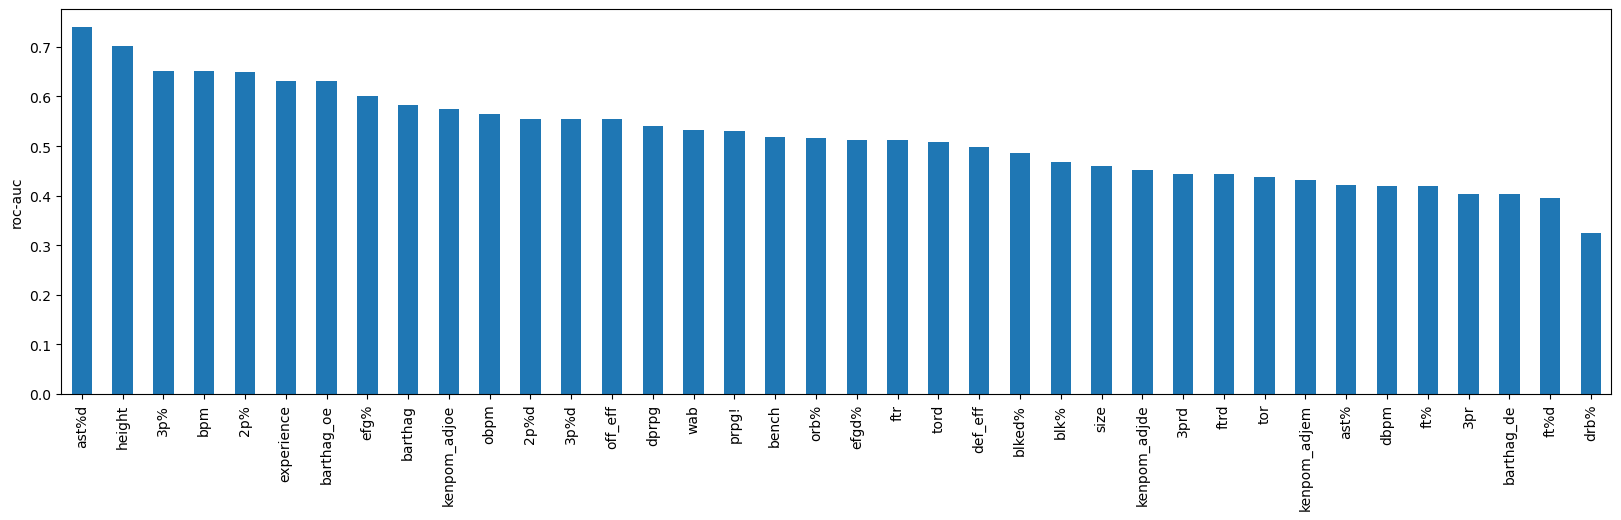

In [23]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [24]:
len(roc_values[roc_values > 0.6])

8

In [25]:
roc_values[roc_values > 0.6]

bpm          0.6516
barthag_oe   0.6303
efg%         0.6015
2p%          0.6491
3p%          0.6516
ast%d        0.7393
height       0.7018
experience   0.6316
dtype: float64

In [26]:
roc_values[roc_values > 0.65]

bpm      0.6516
3p%      0.6516
ast%d    0.7393
height   0.7018
dtype: float64

In [83]:
roc_values[roc_values > 0.62]

bpm          0.6516
barthag_oe   0.6303
2p%          0.6491
3p%          0.6516
ast%d        0.7393
height       0.7018
experience   0.6316
dtype: float64

# III. XGBoost

In [96]:
X_train_scaled2 = X_train_scaled[[
'bpm',
'barthag_oe',
'2p%',
'3p%',
'ast%d',
'height',
'experience'
]]

X_test_scaled2 = X_test_scaled[[
'bpm',
'barthag_oe',
'2p%',
'3p%',
'ast%d',
'height',
'experience'
]]

In [97]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.3}


In [98]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [99]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.5742978334677912


In [100]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {acc_train:.2f}")
print(f"F1 Score on Test Data: {acc_test:.2f}")

F1 Score on Training Data: 0.88
F1 Score on Test Data: 0.70


<Figure size 1000x600 with 0 Axes>

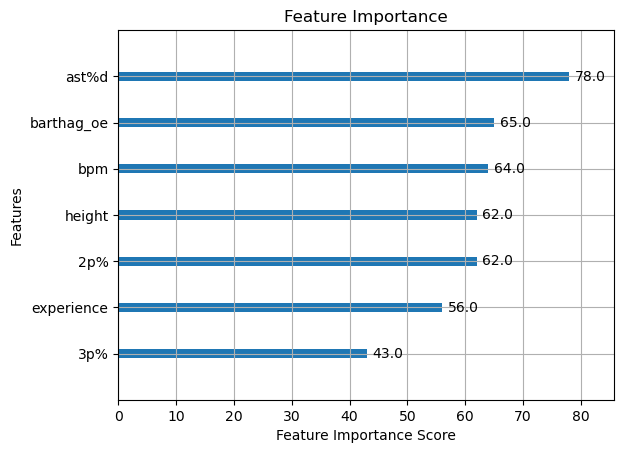

In [101]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()